### Imports

In [1]:
import geojson as gj
import matplotlib.pyplot as plt
import folium as fl
import geopandas as gpd
import json
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import haversine as hs
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Borderpoints

### Reading the CSV

In [2]:
borderpoints_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_BorderPoints.csv', delimiter=';')

borderpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_BP_0,Almeria,['INET_BP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
1,INET_BP_1,Alveringem,['INET_BP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,"{'end_year': 2050, 'pipe_name': 'Alveringem-Ma...","{'end_year': 20, 'pipe_name': 0, 'start_year':...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
2,INET_BP_2,Arnoldstein,['INET_BP_2'],['INET_N_76'],46.5499903,13.7057619,AT,None,"{'end_year': 2050, 'pipe_name': 'medgaz', 'sta...","{'end_year': 20, 'pipe_name': 0, 'start_year':...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
3,INET_BP_3,Backi Breg,['INET_BP_3'],['INET_N_1387'],45.78,19.12,RS,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
4,INET_BP_4,Badajoz,['INET_BP_4'],['INET_N_108'],38.87665,-6.9714,ES,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None


### Splitting columns

In [3]:
borderpoints_gdf['param'] = borderpoints_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(borderpoints_gdf['param'])
borderpoints_gdf = borderpoints_gdf.drop(columns=['param']).join(param_df)

borderpoints_gdf['uncertainty'] = borderpoints_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(borderpoints_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
borderpoints_gdf = borderpoints_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

borderpoints_gdf['method'] = borderpoints_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(borderpoints_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
borderpoints_gdf = borderpoints_gdf.drop(columns=['method']).join(method_df)

borderpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,end_year,pipe_name,start_year,uncertainty_end_year,uncertainty_pipe_name,uncertainty_start_year,method_end_year,method_pipe_name,method_start_year
0,INET_BP_0,Almeria,['INET_BP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
1,INET_BP_1,Alveringem,['INET_BP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,{},None,2050,Alveringem-Maldegem pipeline,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
2,INET_BP_2,Arnoldstein,['INET_BP_2'],['INET_N_76'],46.5499903,13.7057619,AT,None,{},None,2050,medgaz,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
3,INET_BP_3,Backi Breg,['INET_BP_3'],['INET_N_1387'],45.78,19.12,RS,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
4,INET_BP_4,Badajoz,['INET_BP_4'],['INET_N_108'],38.87665,-6.9714,ES,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)


### Cleaning the data

In [4]:
borderpoints_gdf = borderpoints_gdf.drop(columns=['tags'])

borderpoints_gdf['lat'] = borderpoints_gdf['lat'].astype('float64')
borderpoints_gdf['long'] = borderpoints_gdf['long'].astype('float64')

borderpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,pipe_name,start_year,uncertainty_end_year,uncertainty_pipe_name,uncertainty_start_year,method_end_year,method_pipe_name,method_start_year
0,INET_BP_0,Almeria,['INET_BP_0'],['INET_N_38'],36.734800,-2.303600,ES,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
1,INET_BP_1,Alveringem,['INET_BP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,None,2050,Alveringem-Maldegem pipeline,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
2,INET_BP_2,Arnoldstein,['INET_BP_2'],['INET_N_76'],46.549990,13.705762,AT,None,None,2050,medgaz,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
3,INET_BP_3,Backi Breg,['INET_BP_3'],['INET_N_1387'],45.780000,19.120000,RS,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
4,INET_BP_4,Badajoz,['INET_BP_4'],['INET_N_108'],38.876650,-6.971400,ES,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)


## Compressors

### Reading the CSV

In [5]:
compressors_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Compressors.csv')

compressors_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_CO_0,Aberdeen,['INET_CO_0'],['INET_N_2'],57.13600455,-2.379727732,GB,None,"{'end_year': 2050, 'is_H_gas': 1.0, 'max_cap_M...","{'end_year': 20, 'is_H_gas': 0, 'max_cap_M_m3_...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
1,INET_CO_1,Achim,['INET_CO_1'],['INET_N_435'],53.0268,9.022361,DE,None,"{'end_year': 2050, 'is_H_gas': 1.0, 'max_cap_M...","{'end_year': 20, 'is_H_gas': 0, 'max_cap_M_m3_...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
2,INET_CO_2,Ajdovscina,['INET_CO_2'],['INET_N_1344'],45.9266,13.65005,SI,None,"{'end_year': 2050, 'is_H_gas': 1.0, 'max_cap_M...","{'end_year': 20, 'is_H_gas': 0, 'max_cap_M_m3_...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
3,INET_CO_3,Alcazar De San Juan,['INET_CO_3'],['INET_N_23'],39.390074799999994,-3.3500984,ES,None,"{'end_year': 2050, 'is_H_gas': 1.0, 'max_cap_M...","{'end_year': 20, 'is_H_gas': 0, 'max_cap_M_m3_...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
4,INET_CO_5,Algete,['INET_CO_5'],['INET_N_31'],40.585921,-3.5458019999999997,ES,None,"{'end_year': 2050, 'is_H_gas': 1.0, 'max_cap_M...","{'end_year': 20, 'is_H_gas': 0, 'max_cap_M_m3_...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None


### Splitting columns

In [6]:
compressors_gdf['param'] = compressors_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(compressors_gdf['param'])
compressors_gdf = compressors_gdf.drop(columns=['param']).join(param_df)

compressors_gdf['uncertainty'] = compressors_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(compressors_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
compressors_gdf = compressors_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

compressors_gdf['method'] = compressors_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(compressors_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
compressors_gdf = compressors_gdf.drop(columns=['method']).join(method_df)

compressors_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,...,method_turbine_fuel_isGas_3,method_turbine_fuel_isGas_4,method_turbine_fuel_isGas_5,method_turbine_fuel_isGas_6,method_turbine_power_1_MW,method_turbine_power_2_MW,method_turbine_power_3_MW,method_turbine_power_4_MW,method_turbine_power_5_MW,method_turbine_power_6_MW
0,INET_CO_0,Aberdeen,['INET_CO_0'],['INET_N_2'],57.13600455,-2.379727732,GB,None,{},None,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
1,INET_CO_1,Achim,['INET_CO_1'],['INET_N_435'],53.0268,9.022361,DE,None,{},None,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
2,INET_CO_2,Ajdovscina,['INET_CO_2'],['INET_N_1344'],45.9266,13.65005,SI,None,{},None,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
3,INET_CO_3,Alcazar De San Juan,['INET_CO_3'],['INET_N_23'],39.390074799999994,-3.3500984,ES,None,{},None,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
4,INET_CO_5,Algete,['INET_CO_5'],['INET_N_31'],40.585921,-3.5458019999999997,ES,None,{},None,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None


### Cleaning the data

In [7]:
compressors_gdf = compressors_gdf.drop(columns=['tags'])

compressors_gdf['lat'] = compressors_gdf['lat'].astype('float64')
compressors_gdf['long'] = compressors_gdf['long'].astype('float64')

compressors_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,...,method_turbine_fuel_isGas_3,method_turbine_fuel_isGas_4,method_turbine_fuel_isGas_5,method_turbine_fuel_isGas_6,method_turbine_power_1_MW,method_turbine_power_2_MW,method_turbine_power_3_MW,method_turbine_power_4_MW,method_turbine_power_5_MW,method_turbine_power_6_MW
0,INET_CO_0,Aberdeen,['INET_CO_0'],['INET_N_2'],57.136005,-2.379728,GB,None,None,2050,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
1,INET_CO_1,Achim,['INET_CO_1'],['INET_N_435'],53.026800,9.022361,DE,None,None,2050,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
2,INET_CO_2,Ajdovscina,['INET_CO_2'],['INET_N_1344'],45.926600,13.650050,SI,None,None,2050,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
3,INET_CO_3,Alcazar De San Juan,['INET_CO_3'],['INET_N_23'],39.390075,-3.350098,ES,None,None,2050,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None
4,INET_CO_5,Algete,['INET_CO_5'],['INET_N_31'],40.585921,-3.545802,ES,None,None,2050,...,make_Attrib(const),make_Attrib(const),make_Attrib(const),make_Attrib(const),Lasso,Lasso,Lasso,None,None,None


## Entry points

### Reading the CSV

In [8]:
entrypoints_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_EntryPoints.csv')

entrypoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_EP_0,Almeria,['INET_EP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,"{'end_year': 2050, 'start_year': 1983}","{'end_year': 20, 'start_year': 20}","{'end_year': 'make_Attrib(const)', 'start_year...",{},None
1,INET_EP_1,Bacton,['INET_EP_1'],['INET_N_103'],52.8506,1.466,GB,None,"{'end_year': 2050, 'start_year': 1983}","{'end_year': 20, 'start_year': 20}","{'end_year': 'make_Attrib(const)', 'start_year...",{},None
2,INET_EP_2,Balgzand,['INET_EP_2'],['INET_N_65'],52.86,4.822,NL,None,"{'end_year': 2050, 'start_year': 1983}","{'end_year': 20, 'start_year': 20}","{'end_year': 'make_Attrib(const)', 'start_year...",{},None
3,INET_EP_3,Beregdaroc,['INET_EP_3'],['INET_N_151'],48.198510799999994,22.5320069,HU,None,"{'end_year': 2050, 'start_year': 1983}","{'end_year': 20, 'start_year': 20}","{'end_year': 'make_Attrib(const)', 'start_year...",{},None
4,INET_EP_4,Budince,['INET_EP_4'],['INET_N_1560'],48.552002,22.121625,SI,None,"{'end_year': 2050, 'start_year': 1983}","{'end_year': 20, 'start_year': 20}","{'end_year': 'make_Attrib(const)', 'start_year...",{},None


### Splitting columns

In [9]:
entrypoints_gdf['param'] = entrypoints_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(entrypoints_gdf['param'])
entrypoints_gdf = entrypoints_gdf.drop(columns=['param']).join(param_df)

entrypoints_gdf['uncertainty'] = entrypoints_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(entrypoints_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
entrypoints_gdf = entrypoints_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

entrypoints_gdf['method'] = entrypoints_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(entrypoints_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
entrypoints_gdf = entrypoints_gdf.drop(columns=['method']).join(method_df)

entrypoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,end_year,start_year,uncertainty_end_year,uncertainty_start_year,method_end_year,method_start_year
0,INET_EP_0,Almeria,['INET_EP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,{},None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
1,INET_EP_1,Bacton,['INET_EP_1'],['INET_N_103'],52.8506,1.466,GB,None,{},None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
2,INET_EP_2,Balgzand,['INET_EP_2'],['INET_N_65'],52.86,4.822,NL,None,{},None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
3,INET_EP_3,Beregdaroc,['INET_EP_3'],['INET_N_151'],48.198510799999994,22.5320069,HU,None,{},None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
4,INET_EP_4,Budince,['INET_EP_4'],['INET_N_1560'],48.552002,22.121625,SI,None,{},None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)


### Cleaning the data

In [10]:
entrypoints_gdf = entrypoints_gdf.drop(columns=['tags'])

entrypoints_gdf['lat'] = entrypoints_gdf['lat'].astype('float64')
entrypoints_gdf['long'] = entrypoints_gdf['long'].astype('float64')

entrypoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,start_year,uncertainty_end_year,uncertainty_start_year,method_end_year,method_start_year
0,INET_EP_0,Almeria,['INET_EP_0'],['INET_N_38'],36.734800,-2.303600,ES,None,None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
1,INET_EP_1,Bacton,['INET_EP_1'],['INET_N_103'],52.850600,1.466000,GB,None,None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
2,INET_EP_2,Balgzand,['INET_EP_2'],['INET_N_65'],52.860000,4.822000,NL,None,None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
3,INET_EP_3,Beregdaroc,['INET_EP_3'],['INET_N_151'],48.198511,22.532007,HU,None,None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)
4,INET_EP_4,Budince,['INET_EP_4'],['INET_N_1560'],48.552002,22.121625,SI,None,None,2050,1983,20,20,make_Attrib(const),make_Attrib(const)


## Interconnection points

### Reading the CSV

In [11]:
interconnectionpoints_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_InterConnectionPoints.csv')

interconnectionpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_IP_0,Almeria,['INET_IP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
1,INET_IP_1,Alveringem,['INET_IP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,"{'end_year': 2050, 'pipe_name': 'Alveringem-Ma...","{'end_year': 20, 'pipe_name': 0, 'start_year':...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
2,INET_IP_2,Arnoldstein,['INET_IP_2'],['INET_N_76'],46.5499903,13.7057619,AT,None,"{'end_year': 2050, 'pipe_name': 'medgaz', 'sta...","{'end_year': 20, 'pipe_name': 0, 'start_year':...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
3,INET_IP_3,Backi Breg,['INET_IP_3'],['INET_N_1387'],45.78,19.12,RS,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None
4,INET_IP_4,Badajoz,['INET_IP_4'],['INET_N_108'],38.87665,-6.9714,ES,None,"{'end_year': 2050, 'pipe_name': None, 'start_y...","{'end_year': 20, 'pipe_name': None, 'start_yea...","{'end_year': 'make_Attrib(const)', 'pipe_name'...",{},None


### Splitting columns

In [12]:
interconnectionpoints_gdf['param'] = interconnectionpoints_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(interconnectionpoints_gdf['param'])
interconnectionpoints_gdf = interconnectionpoints_gdf.drop(columns=['param']).join(param_df)

interconnectionpoints_gdf['uncertainty'] = interconnectionpoints_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(interconnectionpoints_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
interconnectionpoints_gdf = interconnectionpoints_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

interconnectionpoints_gdf['method'] = interconnectionpoints_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(interconnectionpoints_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
interconnectionpoints_gdf = interconnectionpoints_gdf.drop(columns=['method']).join(method_df)

interconnectionpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,end_year,pipe_name,start_year,uncertainty_end_year,uncertainty_pipe_name,uncertainty_start_year,method_end_year,method_pipe_name,method_start_year
0,INET_IP_0,Almeria,['INET_IP_0'],['INET_N_38'],36.7348,-2.3036,ES,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
1,INET_IP_1,Alveringem,['INET_IP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,{},None,2050,Alveringem-Maldegem pipeline,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
2,INET_IP_2,Arnoldstein,['INET_IP_2'],['INET_N_76'],46.5499903,13.7057619,AT,None,{},None,2050,medgaz,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
3,INET_IP_3,Backi Breg,['INET_IP_3'],['INET_N_1387'],45.78,19.12,RS,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
4,INET_IP_4,Badajoz,['INET_IP_4'],['INET_N_108'],38.87665,-6.9714,ES,None,{},None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)


### Cleaning the data

In [13]:
interconnectionpoints_gdf = interconnectionpoints_gdf.drop(columns=['tags'])

interconnectionpoints_gdf['lat'] = interconnectionpoints_gdf['lat'].astype('float64')
interconnectionpoints_gdf['long'] = interconnectionpoints_gdf['long'].astype('float64')

interconnectionpoints_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,pipe_name,start_year,uncertainty_end_year,uncertainty_pipe_name,uncertainty_start_year,method_end_year,method_pipe_name,method_start_year
0,INET_IP_0,Almeria,['INET_IP_0'],['INET_N_38'],36.734800,-2.303600,ES,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
1,INET_IP_1,Alveringem,['INET_IP_1'],['INET_N_1146'],50.926317,2.315596,BE,None,None,2050,Alveringem-Maldegem pipeline,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
2,INET_IP_2,Arnoldstein,['INET_IP_2'],['INET_N_76'],46.549990,13.705762,AT,None,None,2050,medgaz,1983,20,0.0,20,make_Attrib(const),raw,make_Attrib(const)
3,INET_IP_3,Backi Breg,['INET_IP_3'],['INET_N_1387'],45.780000,19.120000,RS,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)
4,INET_IP_4,Badajoz,['INET_IP_4'],['INET_N_108'],38.876650,-6.971400,ES,None,None,2050,None,1983,20,NaN,20,make_Attrib(const),None,make_Attrib(const)


## LNG terminals

### Reading the CSV

In [14]:
lng_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_LNGs.csv')

lng_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_LG_0,Alexandroupolis,['INET_LG_0'],['INET_N_28'],40.9399278,25.9940986,GR,None,"{'end_year': 2050, 'max_cap_store2pipe_M_m3_pe...","{'end_year': 20, 'max_cap_store2pipe_M_m3_per_...","{'end_year': 'make_Attrib(const)', 'max_cap_st...",{},None
1,INET_LG_1,Barcelona,"['INET_LG_1', 'GIE_LG_2']",['INET_N_129'],41.398,2.174,ES,None,"{'end_year': 2050, 'max_cap_store2pipe_M_m3_pe...","{'end_year': 20, 'max_cap_store2pipe_M_m3_per_...","{'end_year': 'make_Attrib(const)', 'max_cap_st...",{},None
2,INET_LG_2,Bilbao,"['INET_LG_2', 'GIE_LG_1']",['INET_N_170'],43.3612,-3.0947299999999998,ES,None,"{'end_year': 2050, 'max_cap_store2pipe_M_m3_pe...","{'end_year': 20, 'max_cap_store2pipe_M_m3_per_...","{'end_year': 'make_Attrib(const)', 'max_cap_st...",{},None
3,INET_LG_4,Cartagena,"['INET_LG_4', 'GIE_LG_3']",['INET_N_260'],37.624,-0.998,ES,None,"{'end_year': 2050, 'max_cap_store2pipe_M_m3_pe...","{'end_year': 20, 'max_cap_store2pipe_M_m3_per_...","{'end_year': 'make_Attrib(const)', 'max_cap_st...",{},None
4,INET_LG_6,Dragon,['INET_LG_6'],['INET_N_965'],51.71,-5.03,GB,Milford Haven South Wales,"{'end_year': 2050, 'max_cap_store2pipe_M_m3_pe...","{'end_year': 20, 'max_cap_store2pipe_M_m3_per_...","{'end_year': 'make_Attrib(const)', 'max_cap_st...",{},None


### Splitting columns

In [15]:
lng_gdf['param'] = lng_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(lng_gdf['param'])
lng_gdf = lng_gdf.drop(columns=['param']).join(param_df)

lng_gdf['uncertainty'] = lng_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(lng_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
lng_gdf = lng_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

lng_gdf['method'] = lng_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(lng_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
lng_gdf = lng_gdf.drop(columns=['method']).join(method_df)

lng_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,...,uncertainty_max_workingGas_M_m3,uncertainty_median_cap_store2pipe_M_m3_per_d,uncertainty_start_year,uncertainty_is_H_gas,method_end_year,method_max_cap_store2pipe_M_m3_per_d,method_max_workingGas_M_m3,method_median_cap_store2pipe_M_m3_per_d,method_start_year,method_is_H_gas
0,INET_LG_0,Alexandroupolis,['INET_LG_0'],['INET_N_28'],40.9399278,25.9940986,GR,None,{},None,...,0.0,1.137766,0,0.5,make_Attrib(const),raw,raw,Lasso,raw,make_Attrib(const)
1,INET_LG_1,Barcelona,"['INET_LG_1', 'GIE_LG_2']",['INET_N_129'],41.398,2.174,ES,None,{},None,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
2,INET_LG_2,Bilbao,"['INET_LG_2', 'GIE_LG_1']",['INET_N_170'],43.3612,-3.0947299999999998,ES,None,{},None,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
3,INET_LG_4,Cartagena,"['INET_LG_4', 'GIE_LG_3']",['INET_N_260'],37.624,-0.998,ES,None,{},None,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
4,INET_LG_6,Dragon,['INET_LG_6'],['INET_N_965'],51.71,-5.03,GB,Milford Haven South Wales,{},None,...,0.0,1.137766,0,0.5,make_Attrib(const),raw,raw,Lasso,raw,make_Attrib(const)


### Cleaning the data

In [16]:
lng_gdf = lng_gdf.drop(columns=['tags'])

lng_gdf['lat'] = lng_gdf['lat'].astype('float64')
lng_gdf['long'] = lng_gdf['long'].astype('float64')

lng_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,...,uncertainty_max_workingGas_M_m3,uncertainty_median_cap_store2pipe_M_m3_per_d,uncertainty_start_year,uncertainty_is_H_gas,method_end_year,method_max_cap_store2pipe_M_m3_per_d,method_max_workingGas_M_m3,method_median_cap_store2pipe_M_m3_per_d,method_start_year,method_is_H_gas
0,INET_LG_0,Alexandroupolis,['INET_LG_0'],['INET_N_28'],40.939928,25.994099,GR,None,None,2050,...,0.0,1.137766,0,0.5,make_Attrib(const),raw,raw,Lasso,raw,make_Attrib(const)
1,INET_LG_1,Barcelona,"['INET_LG_1', 'GIE_LG_2']",['INET_N_129'],41.398000,2.174000,ES,None,None,2050,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
2,INET_LG_2,Bilbao,"['INET_LG_2', 'GIE_LG_1']",['INET_N_170'],43.361200,-3.094730,ES,None,None,2050,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
3,INET_LG_4,Cartagena,"['INET_LG_4', 'GIE_LG_3']",['INET_N_260'],37.624000,-0.998000,ES,None,None,2050,...,0.0,0.000000,0,0.5,make_Attrib(const),raw,raw,raw,raw,make_Attrib(const)
4,INET_LG_6,Dragon,['INET_LG_6'],['INET_N_965'],51.710000,-5.030000,GB,Milford Haven South Wales,None,2050,...,0.0,1.137766,0,0.5,make_Attrib(const),raw,raw,Lasso,raw,make_Attrib(const)


## Nodes

### Reading the CSV

In [17]:
# Load the file "/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.geojson" into a GeoDataFrame
nodes_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.csv')

nodes_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,NO_N_0,N_0,['NO_307674'],['NO_N_0'],65.10639924578797,6.797201226775478,NO,None,"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",{},None
1,NO_N_1,N_1,['NO_307674'],['NO_N_1'],59.33285970703154,5.193570754034167,NO,None,"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",{},None
2,NO_N_2,N_2,['NO_309000'],['NO_N_2'],60.56023487203963,2.895754899438161,NO,None,"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",{},None
3,NO_N_3,N_3,['NO_309000'],['NO_N_3'],60.78219442047412,2.8961421395531044,NO,None,"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",{},None
4,NO_N_4,N_4,['NO_310326'],['NO_N_4'],54.788771978218385,3.2983729818980376,NO,None,"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",{},None


### Splitting columns

In [18]:
nodes_gdf['param'] = nodes_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(nodes_gdf['param'])
nodes_gdf = nodes_gdf.drop(columns=['param']).join(param_df)

nodes_gdf['uncertainty'] = nodes_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(nodes_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
nodes_gdf = nodes_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

nodes_gdf['method'] = nodes_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(nodes_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
nodes_gdf = nodes_gdf.drop(columns=['method']).join(method_df)

nodes_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,...,exact,name_short,uncertainty_eic_code,uncertainty_elevation_m,uncertainty_exact,uncertainty_name_short,method_eic_code,method_elevation_m,method_exact,method_name_short
0,NO_N_0,N_0,['NO_307674'],['NO_N_0'],65.10639924578797,6.797201226775478,NO,None,{},None,...,1.0,None,None,NaN,0.0,None,None,None,make_Attrib(const),None
1,NO_N_1,N_1,['NO_307674'],['NO_N_1'],59.33285970703154,5.193570754034167,NO,None,{},None,...,1.0,None,None,NaN,0.0,None,None,None,make_Attrib(const),None
2,NO_N_2,N_2,['NO_309000'],['NO_N_2'],60.56023487203963,2.895754899438161,NO,None,{},None,...,1.0,None,None,NaN,0.0,None,None,None,make_Attrib(const),None
3,NO_N_3,N_3,['NO_309000'],['NO_N_3'],60.78219442047412,2.8961421395531044,NO,None,{},None,...,1.0,None,None,NaN,0.0,None,None,None,make_Attrib(const),None
4,NO_N_4,N_4,['NO_310326'],['NO_N_4'],54.788771978218385,3.2983729818980376,NO,None,{},None,...,1.0,None,None,NaN,0.0,None,None,None,make_Attrib(const),None


### Cleaning the data

In [19]:
nodes_gdf = nodes_gdf.drop(columns=['tags'])

# Drop all cols starting with uncertainty_ and method_
nodes_gdf = nodes_gdf.drop(columns=[col for col in nodes_gdf.columns if 'uncertainty_' in col or 'method_' in col])

nodes_gdf['lat'] = nodes_gdf['lat'].astype('float64')
nodes_gdf['long'] = nodes_gdf['long'].astype('float64')

nodes_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,eic_code,elevation_m,exact,name_short
0,NO_N_0,N_0,['NO_307674'],['NO_N_0'],65.106399,6.797201,NO,None,None,None,NaN,1.0,None
1,NO_N_1,N_1,['NO_307674'],['NO_N_1'],59.332860,5.193571,NO,None,None,None,NaN,1.0,None
2,NO_N_2,N_2,['NO_309000'],['NO_N_2'],60.560235,2.895755,NO,None,None,None,NaN,1.0,None
3,NO_N_3,N_3,['NO_309000'],['NO_N_3'],60.782194,2.896142,NO,None,None,None,NaN,1.0,None
4,NO_N_4,N_4,['NO_310326'],['NO_N_4'],54.788772,3.298373,NO,None,None,None,NaN,1.0,None


## Pipelines

### Reading the CSV

In [20]:
# Open the file: "/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv" as a GeoDataFrame: gdf
pipelines_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv')

pipelines_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"['INET_N_23', 'INET_N_295']","[39.3900748, 38.892435]","[-3.3500984, -1.719831]","['ES', 'ES']",None,"{'diameter_mm': 923.7925292425738, 'end_year':...","{'diameter_mm': 187.6635273358689, 'end_year':...","{'diameter_mm': 'Lasso', 'end_year': 'make_Att...",{},None
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"['INET_N_1460', 'INET_N_904']","[40.01, 40.223]","[-3.207, -3.681]","['ES', 'ES']",None,"{'diameter_mm': 923.7925292425738, 'end_year':...","{'diameter_mm': 187.6635273358689, 'end_year':...","{'diameter_mm': 'Lasso', 'end_year': 'make_Att...",{},None
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"['INET_N_317', 'INET_N_26']","[44.991076, 44.90008]","[9.920891, 8.60944]","['IT', 'IT']",None,"{'diameter_mm': 914.4, 'end_year': 2050, 'is_H...","{'diameter_mm': 0, 'end_year': 20, 'is_H_gas':...","{'diameter_mm': 'raw', 'end_year': 'make_Attri...",{},None
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"['INET_N_36', 'INET_N_108']","[38.711202, 38.87665]","[-6.382539, -6.9714]","['ES', 'ES']",None,"{'diameter_mm': 923.7925292425738, 'end_year':...","{'diameter_mm': 187.6635273358689, 'end_year':...","{'diameter_mm': 'Lasso', 'end_year': 'make_Att...",{},None
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"['INET_N_36', 'INET_N_1653']","[38.711202, 41.506]","[-6.382539, -5.644]","['ES', 'ES']",None,"{'diameter_mm': 923.7925292425738, 'end_year':...","{'diameter_mm': 187.6635273358689, 'end_year':...","{'diameter_mm': 'Lasso', 'end_year': 'make_Att...",{},None


### Splitting columns

In [21]:
from ast import literal_eval
# Split the 'param' column into separate columns
pipelines_gdf['param'] = pipelines_gdf['param'].apply(lambda x: json.loads(x.replace("'", '"')))
param_df = pd.json_normalize(pipelines_gdf['param'])
pipelines_gdf = pipelines_gdf.drop(columns=['param']).join(param_df)

# Split the 'uncertainty' column into separate columns and add them to the GeoDataFrame, prefaced by the string 'uncertainty_'
pipelines_gdf['uncertainty'] = pipelines_gdf['uncertainty'].apply(lambda x: json.loads(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(pipelines_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
pipelines_gdf = pipelines_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

# Split the 'method' column into separate columns and add them to the GeoDataFrame, prefaced by the string 'method_'
pipelines_gdf['method'] = pipelines_gdf['method'].apply(lambda x: json.loads(x.replace("'", '"')))
method_df = pd.json_normalize(pipelines_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
pipelines_gdf = pipelines_gdf.drop(columns=['method']).join(method_df)

# Split the "country_code" column into two separate columns. "['ES', 'ES']" is an example of a value in the "country_code" column
pipelines_gdf['country_code'] = pipelines_gdf['country_code'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').split(', '))
country_code_df = pd.DataFrame(pipelines_gdf['country_code'].to_list(), columns=['country_code_1', 'country_code_2'])
pipelines_gdf = pipelines_gdf.drop(columns=['country_code']).join(country_code_df)

# Split the node_id column into two separate columns. "['INET_N_23', 'INET_N_295']" is an example of a value in the "node_id" column
pipelines_gdf['node_id'] = pipelines_gdf['node_id'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').split(', '))
node_id_df = pd.DataFrame(pipelines_gdf['node_id'].to_list(), columns=['node_id_1', 'node_id_2'])
pipelines_gdf = pipelines_gdf.drop(columns=['node_id']).join(node_id_df)

# Print the first few rows of the GeoDataFrame
pipelines_gdf.head()

,id,name,source_id,lat,long,comment,tags,geometry,diameter_mm,end_year,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,{},None,914.400000,2050,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


### Cleaning the data

In [22]:
pipelines_gdf = pipelines_gdf.drop(columns=['tags'])

pipelines_gdf['lat'] = pipelines_gdf['lat'].apply(lambda x: [float(i) for i in literal_eval(x)])
pipelines_gdf['long'] = pipelines_gdf['long'].apply(lambda x: [float(i) for i in literal_eval(x)])

pipelines_gdf.head()

,id,name,source_id,lat,long,comment,geometry,diameter_mm,end_year,is_H_gas,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,None,923.792529,2050,1.0,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,None,923.792529,2050,1.0,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,None,914.400000,2050,1.0,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,None,923.792529,2050,1.0,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,None,923.792529,2050,1.0,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


## Storages

### Reading the CSV

In [23]:
storages_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Storages.csv')

storages_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,param,uncertainty,method,tags,geometry
0,INET_SR_0,7Fields,"['INET_SR_0', 'GSE_SR_10']",['INET_N_587'],47.9867,13.232375,AT,Storage Capacity connected to Germany and Austria,"{'end_year': 2050, 'is_H_gas': 1, 'max_cap_pip...","{'end_year': 20, 'is_H_gas': 0.5, 'max_cap_pip...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
1,INET_SR_1,Aigelsbrunn,"['INET_SR_1', 'GSE_SR_5']",['INET_N_587'],47.9867,13.232375,AT,None,"{'end_year': 2050, 'is_H_gas': 1, 'max_cap_pip...","{'end_year': 20, 'is_H_gas': 0.5, 'max_cap_pip...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
2,INET_SR_2,Aldbrough1,"['INET_SR_2', 'GSE_SR_211']",['NO_N_39'],53.65843335049228,0.11455133161561178,GB,None,"{'end_year': 2050, 'is_H_gas': 1, 'max_cap_pip...","{'end_year': 20, 'is_H_gas': 0.5, 'max_cap_pip...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
3,INET_SR_3,Aldbrough2,['INET_SR_3'],['NO_N_39'],53.65843335049228,0.11455133161561178,GB,None,"{'end_year': 2050, 'is_H_gas': 1, 'max_cap_pip...","{'end_year': 20, 'is_H_gas': 0.5, 'max_cap_pip...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None
4,INET_SR_4,Alfonsine,['INET_SR_4'],['INET_N_263'],44.554176,12.264301,IT,None,"{'end_year': 2050, 'is_H_gas': 1, 'max_cap_pip...","{'end_year': 20, 'is_H_gas': 0.5, 'max_cap_pip...","{'end_year': 'make_Attrib(const)', 'is_H_gas':...",{},None


### Splitting columns

In [24]:
storages_gdf['param'] = storages_gdf['param'].apply(lambda x: eval(x.replace("'", '"')))
param_df = pd.json_normalize(storages_gdf['param'])
storages_gdf = storages_gdf.drop(columns=['param']).join(param_df)

storages_gdf['uncertainty'] = storages_gdf['uncertainty'].apply(lambda x: eval(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(storages_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
storages_gdf = storages_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

storages_gdf['method'] = storages_gdf['method'].apply(lambda x: eval(x.replace("'", '"')))
method_df = pd.json_normalize(storages_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
storages_gdf = storages_gdf.drop(columns=['method']).join(method_df)

storages_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,tags,geometry,...,method_max_storage_pressure_bar,method_max_workingGas_M_m3,method_min_storage_pressure_bar,method_net_thickness_m,method_num_storage_wells,method_permeability_mD,method_porosity_perc,method_start_year,method_storage_formation,method_structure_depth_m
0,INET_SR_0,7Fields,"['INET_SR_0', 'GSE_SR_10']",['INET_N_587'],47.9867,13.232375,AT,Storage Capacity connected to Germany and Austria,{},None,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
1,INET_SR_1,Aigelsbrunn,"['INET_SR_1', 'GSE_SR_5']",['INET_N_587'],47.9867,13.232375,AT,None,{},None,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
2,INET_SR_2,Aldbrough1,"['INET_SR_2', 'GSE_SR_211']",['NO_N_39'],53.65843335049228,0.11455133161561178,GB,None,{},None,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
3,INET_SR_3,Aldbrough2,['INET_SR_3'],['NO_N_39'],53.65843335049228,0.11455133161561178,GB,None,{},None,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
4,INET_SR_4,Alfonsine,['INET_SR_4'],['INET_N_263'],44.554176,12.264301,IT,None,{},None,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso


### Cleaning the data

In [25]:
storages_gdf = storages_gdf.drop(columns=['tags'])

storages_gdf['lat'] = storages_gdf['lat'].astype('float64')
storages_gdf['long'] = storages_gdf['long'].astype('float64')
storages_gdf['end_year'] = storages_gdf['end_year'].astype('int64')


storages_gdf.head()

,id,name,source_id,node_id,lat,long,country_code,comment,geometry,end_year,...,method_max_storage_pressure_bar,method_max_workingGas_M_m3,method_min_storage_pressure_bar,method_net_thickness_m,method_num_storage_wells,method_permeability_mD,method_porosity_perc,method_start_year,method_storage_formation,method_structure_depth_m
0,INET_SR_0,7Fields,"['INET_SR_0', 'GSE_SR_10']",['INET_N_587'],47.986700,13.232375,AT,Storage Capacity connected to Germany and Austria,None,2050,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
1,INET_SR_1,Aigelsbrunn,"['INET_SR_1', 'GSE_SR_5']",['INET_N_587'],47.986700,13.232375,AT,None,None,2050,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
2,INET_SR_2,Aldbrough1,"['INET_SR_2', 'GSE_SR_211']",['NO_N_39'],53.658433,0.114551,GB,None,None,2050,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
3,INET_SR_3,Aldbrough2,['INET_SR_3'],['NO_N_39'],53.658433,0.114551,GB,None,None,2050,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso
4,INET_SR_4,Alfonsine,['INET_SR_4'],['INET_N_263'],44.554176,12.264301,IT,None,None,2050,...,Lasso,raw,Lasso,Median,Lasso,Lasso,Median,raw,None,Lasso


## Plotting using folium

In [26]:
# Create a map object
m = fl.Map(location=[54.5260, 15.2551], zoom_start=4)

# Create a feature group for the compressors
compressors_layer = fl.FeatureGroup(name='Compressors')

# Plot the compressors_gdf on the map with red markers
for index, row in compressors_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='yellow')).add_to(compressors_layer)

# Add the compressors layer to the map
compressors_layer.add_to(m)

# Create a feature group for border points
borderpoints_layer = fl.FeatureGroup(name='Border Points')

# Plot the borderpoints_gdf on the map with blue markers
for index, row in borderpoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='blue')).add_to(borderpoints_layer)

# Add the border points layer to the map
borderpoints_layer.add_to(m)

# Create a feature group for entry points
entrypoints_layer = fl.FeatureGroup(name='Entry Points')

# Plot the entrypoints_gdf on the map with green markers
for index, row in entrypoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='green')).add_to(entrypoints_layer)

# Add the entry points layer to the map
entrypoints_layer.add_to(m)

# Create a feature group for interconnection points
interconnectionpoints_layer = fl.FeatureGroup(name='Interconnection Points')

# Plot the interconnectionpoints_gdf on the map with orange markers
for index, row in interconnectionpoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='orange')).add_to(interconnectionpoints_layer)

# Add the interconnection points layer to the map
interconnectionpoints_layer.add_to(m)

# Create a feature group for LNG terminals
lng_layer = fl.FeatureGroup(name='LNG Terminals')

# Plot the lng_gdf on the map with purple markers
for index, row in lng_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='purple')).add_to(lng_layer)

# Add the LNG terminals layer to the map
lng_layer.add_to(m)

# Create a feature group for storages
storages_layer = fl.FeatureGroup(name='Storages')

# Plot the storages_gdf on the map with yellow markers
for index, row in storages_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='lightgray')).add_to(storages_layer)

# Add the storages layer to the map
storages_layer.add_to(m)

# Create a feature group for nodes
nodes_layer = fl.FeatureGroup(name='Nodes')

# Plot the nodes_gdf on the map with red markers
for index, row in nodes_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='pink')).add_to(nodes_layer)

# Add the nodes layer to the map
nodes_layer.add_to(m)

# Create a feature group for the pipeline segments
pipeline_segments = fl.FeatureGroup(name='Pipeline Segments')

# Iterate through the pipelines_gdf and plot the pipeline segments on the map
for i, row in pipelines_gdf.iterrows():
    fl.PolyLine([(nodes_gdf.loc[nodes_gdf['id'] == row['node_id_1'], 'lat'].values[0], nodes_gdf.loc[nodes_gdf['id'] == row['node_id_1'], 'long'].values[0]),
                        (nodes_gdf.loc[nodes_gdf['id'] == row['node_id_2'], 'lat'].values[0], nodes_gdf.loc[nodes_gdf['id'] == row['node_id_2'], 'long'].values[0])],
                        color='black', weight=2, popup=row['id']).add_to(pipeline_segments)
                        
# Add the pipeline segments layer to the map
pipeline_segments.add_to(m)

# Add layer control to the map
fl.LayerControl().add_to(m)

# Save the map
m.save('complete_map_pre_modification.html')


## Disconnection between Norwegian and continental grids

### Identification of locations

#### Dunkerque: INET_N_407 and NO_N_33

![Image Description](Screenshots/1.png)

#### Zeebrugge: INET_N_1656 and NO_N_5
![Image Description](Screenshots/2.png)

#### Dornmum: INET_N_379, NO_N_27 and Storages_0
![Image Description](Screenshots/3.png)

#### Emden: INET_N_436 and NO_N_19
![Image Description](Screenshots/4.png)

#### Easington: INET_N_410 and NO_N_39
![image.png](Screenshots/8.png)

#### St. Fergus: INET_N_1401 and NO_N_24
![image.png](Screenshots/9.png)

### Connecting Norwegian grid to the continent

In [27]:
# Dunkerque
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_33', 'node_id_1'] = 'INET_N_407'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_33', 'node_id_2'] = 'INET_N_407'

# Zeebrugge
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_5', 'node_id_1'] = 'INET_N_1656'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_5', 'node_id_2'] = 'INET_N_1656'

# Dornum
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_27', 'node_id_1'] = 'INET_N_379'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_27', 'node_id_2'] = 'INET_N_379'
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'Storages_0', 'node_id_1'] = 'INET_N_379'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'Storages_0', 'node_id_2'] = 'INET_N_379'

# Emden
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_19', 'node_id_1'] = 'INET_N_436'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_19', 'node_id_2'] = 'INET_N_436'

# Easington
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_39', 'node_id_1'] = 'INET_N_410'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_39', 'node_id_2'] = 'INET_N_410'

# St. Fergus
pipelines_gdf.loc[pipelines_gdf['node_id_1'] == 'NO_N_24', 'node_id_1'] = 'INET_N_1401'
pipelines_gdf.loc[pipelines_gdf['node_id_2'] == 'NO_N_24', 'node_id_2'] = 'INET_N_1401'

# In the nodes_gdf, drop the rows with the following ids
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_33']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_5']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_27']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_19']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_39']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_24']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'Storages_0']

### Creating a NetworkX graph

In [28]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['long'], row['lat']), country_code=row['country_code'], node_type = [''])

# Add the edges to the graph
for i, row in pipelines_gdf.iterrows():
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])

KeyError: 'length'

### Finding the connected components

In [ ]:
# Find the connected components of the graph, and add this as a new attribute to the nodes using an number
i = 0
for component in nx.connected_components(G.to_undirected()):
    for node in component:
        nodes_gdf.loc[nodes_gdf['id'] == node, 'connected_component'] = i
    i += 1

## Plotting the network post-modification

In [ ]:
# Create a map object
m = fl.Map(location=[54.5260, 15.2551], zoom_start=4)

# Create a feature group for the compressors
compressors_layer = fl.FeatureGroup(name='Compressors')

# Plot the compressors_gdf on the map with red markers
for index, row in compressors_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='yellow')).add_to(compressors_layer)

# Add the compressors layer to the map
compressors_layer.add_to(m)

# Create a feature group for border points
borderpoints_layer = fl.FeatureGroup(name='Border Points')

# Plot the borderpoints_gdf on the map with blue markers
for index, row in borderpoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='blue')).add_to(borderpoints_layer)

# Add the border points layer to the map
borderpoints_layer.add_to(m)

# Create a feature group for entry points
entrypoints_layer = fl.FeatureGroup(name='Entry Points')

# Plot the entrypoints_gdf on the map with green markers
for index, row in entrypoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='green')).add_to(entrypoints_layer)

# Add the entry points layer to the map
entrypoints_layer.add_to(m)

# Create a feature group for interconnection points
interconnectionpoints_layer = fl.FeatureGroup(name='Interconnection Points')

# Plot the interconnectionpoints_gdf on the map with orange markers
for index, row in interconnectionpoints_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='orange')).add_to(interconnectionpoints_layer)

# Add the interconnection points layer to the map
interconnectionpoints_layer.add_to(m)

# Create a feature group for LNG terminals
lng_layer = fl.FeatureGroup(name='LNG Terminals')

# Plot the lng_gdf on the map with purple markers
for index, row in lng_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='purple')).add_to(lng_layer)

# Add the LNG terminals layer to the map
lng_layer.add_to(m)

# Create a feature group for storages
storages_layer = fl.FeatureGroup(name='Storages')

# Plot the storages_gdf on the map with yellow markers
for index, row in storages_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='lightgray')).add_to(storages_layer)

# Add the storages layer to the map
storages_layer.add_to(m)

# Create a feature group for nodes
nodes_layer = fl.FeatureGroup(name='Nodes')

# Plot the nodes_gdf on the map with red markers
for index, row in nodes_gdf.iterrows():
    fl.Marker([row['lat'], row['long']], popup=row['id'], icon=fl.Icon(color='pink')).add_to(nodes_layer)

# Add the nodes layer to the map
nodes_layer.add_to(m)

# Create a feature group for the pipeline segments
pipeline_segments = fl.FeatureGroup(name='Pipeline Segments')

# Iterate through the pipelines_gdf and plot the pipeline segments on the map
for i, row in pipelines_gdf.iterrows():
    
    # Get the connected component of the pipeline
    connected_component = nodes_gdf.loc[nodes_gdf['id'] == row['node_id_1'], 'connected_component'].values[0]
    
    # Set the color based on the connected component
    if connected_component == 0:
        color = 'red'
    else:
        color = 'black'
    
    # Plot the pipeline segment on the map with the corresponding color
    fl.PolyLine([(nodes_gdf.loc[nodes_gdf['id'] == row['node_id_1'], 'lat'].values[0], nodes_gdf.loc[nodes_gdf['id'] == row['node_id_1'], 'long'].values[0]),
                 (nodes_gdf.loc[nodes_gdf['id'] == row['node_id_2'], 'lat'].values[0], nodes_gdf.loc[nodes_gdf['id'] == row['node_id_2'], 'long'].values[0])],
                color=color, weight=2, popup=row['id']).add_to(pipeline_segments)
                        
# Add the pipeline segments layer to the map
pipeline_segments.add_to(m)

# Add layer control to the map
fl.LayerControl().add_to(m)

# Save the map
m.save('complete_map_post_modification.html')

## Topological Analysis

In [ ]:
# Convert the graph to an undirected graph
G_undirected = G.to_undirected()

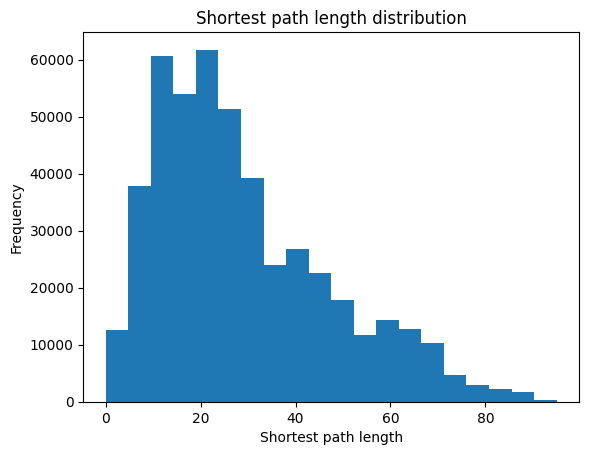

In [ ]:
# Plot a histogram of the shortest path length distribution of the graph G_undirected

# Create a list of the shortest path lengths between all pairs of nodes in the graph G_undirected
shortest_path_lengths = list(nx.shortest_path_length(G_undirected))

# Create a list of the shortest path lengths
shortest_path_lengths = [length for node, length_dict in shortest_path_lengths for target, length in length_dict.items()]

# Plot the histogram of the shortest path lengths
plt.hist(shortest_path_lengths, bins=20)
plt.xlabel('Shortest path length')
plt.ylabel('Frequency')
plt.title('Shortest path length distribution')
plt.show()

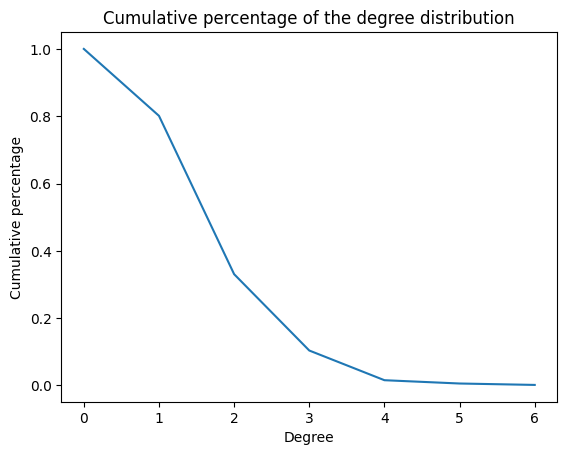

In [ ]:
# Create a list of the degrees of the nodes in the graph G_undirected
degrees = [degree for node, degree in G_undirected.degree()]

# Create a list of the cumulative percentage of the degree distribution
cumulative_percentage = [len([degree for degree in degrees if degree > x])/len(degrees) for x in range(max(degrees))]

# Plot the cumulative percentage of the degree distribution
plt.plot(range(max(degrees)), cumulative_percentage)
plt.xlabel('Degree')
plt.ylabel('Cumulative percentage')
plt.title('Cumulative percentage of the degree distribution')
plt.show()